# Project 1 - churn detection applied to bank scenario
- The object is using data, predict if a customer will become a churn or not

In [251]:
# Imports for data handling
import numpy  as np
import pandas as pd

# Imports for plots
import matplotlib as m
import matplotlib.pyplot as plt
import seaborn as sns

# Imports for machine learning model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import MinMaxScaler
from sklearn.metrics         import accuracy_score

# Import for the logistic regression
from sklearn.linear_model    import LogisticRegression

# Import for the deep learning model
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Nadam
from keras import layers
from keras.utils import to_categorical


## Splitting data for training and evalution of the model

In [252]:
dataset = pd.read_csv('churn.csv')
dataset.shape

(10000, 14)

In [253]:
dataset.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [254]:
y = dataset['Exited']
X = dataset.drop(['Exited'], axis=1)

In [255]:
y.head(5)

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [256]:
X.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [257]:
# Splitting dataset into train and test
# The objective is to use the test dataset as a simulation of real life scenarios, it's important to get some metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data exploration and cleaning

### First check: "text" columns
We cannot use text columns into machine learning models, because of that we need to encode it to numeric representations.
We will use the simplest way to proceed using a technique named *label encoding*.

Even though it can make algorithms misinterpret the numerical labels as having an inherent order or magnitude, we did it because the objective of this project is to focus on the deploy, not on the performance of the model.

__Hint__: When the type is "object" we must understand it as "text"

In [258]:
X_train.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
9254,9255,15601116,P'an,686,France,Male,32,6,0.00,2,1,1,179093.26
1561,1562,15766374,Leak,632,Germany,Male,42,4,119624.60,2,1,1,195978.86
1670,1671,15716994,Green,559,Spain,Male,24,3,114739.92,1,1,0,85891.02
6087,6088,15730759,Chukwudi,561,France,Female,27,9,135637.00,1,1,0,153080.40
6669,6670,15797900,Chinomso,517,France,Male,56,9,142147.32,1,0,0,39488.04


In [259]:
X_train.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
dtype: object

In [260]:
# Showing only text type objects
object_columns = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Object columns: {object_columns}")

Object columns: ['Surname', 'Geography', 'Gender']


### Surname
As we see on the description, this column have no influence in the churn decision because it's only a name.
Because of that we will have no further analysis on it, we will only remove it from de dataframe.

In [261]:
# Removing column
X_train = X_train.drop('Surname', axis = 1)
X_train.head(5)

,RowNumber,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
9254,9255,15601116,686,France,Male,32,6,0.00,2,1,1,179093.26
1561,1562,15766374,632,Germany,Male,42,4,119624.60,2,1,1,195978.86
1670,1671,15716994,559,Spain,Male,24,3,114739.92,1,1,0,85891.02
6087,6088,15730759,561,France,Female,27,9,135637.00,1,1,0,153080.40
6669,6670,15797900,517,France,Male,56,9,142147.32,1,0,0,39488.04


### Geography

In [262]:
# Checking the amount of unique values of the column
X_train.Geography.unique().size

3

In [263]:
# Checking the unique values of the column
X_train.Geography.unique()

array(['France', 'Germany', 'Spain'], dtype=object)

In [264]:
# For this example I'm considering that every time it wil only come those 3 countries.
# In real life there are many ways of handle new inputs (examples: adding new values to "others", creating new categories and retraining the model, excluding it)
country_dict = {"France" : 1,
                "Germany": 2,
                "Spain"  : 3}

In [265]:
# Let's convert the countries to the respective dictionary number 
X_train["Geography"] = X_train.Geography.apply(lambda x: country_dict[x])

In [266]:
X_train.Geography.value_counts()

Geography
1    3994
2    2011
3    1995
Name: count, dtype: int64

### Gender
Even though using gender information can improve model accuracy, it can also amplify biases leading to unfair or discriminatory outcomes.

__Because of that I decided to not use this column__.

In [267]:
# Removing column
X_train = X_train.drop('Gender', axis = 1)
X_train.head(5)

,RowNumber,CustomerId,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
9254,9255,15601116,686,1,32,6,0.00,2,1,1,179093.26
1561,1562,15766374,632,2,42,4,119624.60,2,1,1,195978.86
1670,1671,15716994,559,3,24,3,114739.92,1,1,0,85891.02
6087,6088,15730759,561,1,27,9,135637.00,1,1,0,153080.40
6669,6670,15797900,517,1,56,9,142147.32,1,0,0,39488.04


### Second check: null values
It's not a good practice to use null columns into the machine learning models.
There are many ways to handle that (fill with a value like average, median or other value).
The focus of the project is to show the deployment, because of that I will remove rows with null values to make the proccess quickier.

In [268]:
# Good news: there is not a single row null
X_train.isnull().sum()

RowNumber          0
CustomerId         0
CreditScore        0
Geography          0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [269]:
# If we needed to drop that the command would be:
# X_train = X_train.drop(['RowNumber'], axis = 1) # Remove a column with every row missing
# X_train = X_train.dropna() # Remove all rows with null

### Third check: irrelevant columns
Let's clean the dataframe from irrelevant columns.

In [270]:
# Removing column
X_train = X_train.drop(['RowNumber','CustomerId'], axis = 1)
X_train.head(5)

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
9254,686,1,32,6,0.00,2,1,1,179093.26
1561,632,2,42,4,119624.60,2,1,1,195978.86
1670,559,3,24,3,114739.92,1,1,0,85891.02
6087,561,1,27,9,135637.00,1,1,0,153080.40
6669,517,1,56,9,142147.32,1,0,0,39488.04


### Summary of the cleaning
It's inportant to list it, because in the future we will create a preprocessing script using those steps for new requests.

A. Use only the following columns:
- CreditScore
- Geography
- Age
- Tenure
- Balance
- NumOfProducts
- HasCrCard
- IsActiveMember
- EstimatedSalary

B. The column Geography will be label encoded using a dictionary

## Applying scaler
Even though values from the dataframe now are all numeric, we need to transform all values into the similar range.

__Hint__: Applying the same scale to your columns help the model to avoid bias giving more importance to biggest values.

In [271]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

In [272]:
X_train

array([[0.672     , 0.        , 0.18918919, ..., 1.        , 1.        ,
        0.89555028],
       [0.564     , 0.5       , 0.32432432, ..., 1.        , 1.        ,
        0.98002868],
       [0.418     , 1.        , 0.08108108, ..., 1.        , 0.        ,
        0.42926087],
       ...,
       [0.77      , 0.        , 0.27027027, ..., 0.        , 0.        ,
        0.46092526],
       [0.634     , 0.        , 0.33783784, ..., 1.        , 0.        ,
        0.48738065],
       [0.694     , 0.5       , 0.44594595, ..., 1.        , 1.        ,
        0.26761502]], shape=(8000, 9))

## Test data transformations
Usually while we are handling with the train data, we apply the same transformations to the test data because it's more practical.

For this example I choose to make it in a separate topic to make it clear that the **SAMES TRANSFORMATIONS** must be done.

Don't worry this is not a waste of time because the same thing must be done in the inference script we will create in the future to test this model.

In [273]:
X_test.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
6252,6253,15687492,Anderson,596,Germany,Male,32,3,96709.07,2,0,0,41788.37
4684,4685,15736963,Herring,623,France,Male,43,1,0.00,2,1,1,146379.30
1731,1732,15721730,Amechi,601,Spain,Female,44,4,0.00,2,1,0,58561.31
4742,4743,15762134,Liang,506,Germany,Male,59,8,119152.10,2,1,1,170679.74
4521,4522,15648898,Chuang,560,Spain,Female,27,7,124995.98,1,1,1,114669.79


In [274]:
X_test = X_test.drop('RowNumber', axis = 1)
X_test = X_test.drop('CustomerId', axis = 1)
X_test = X_test.drop('Surname', axis = 1)
X_test = X_test.drop('Gender', axis = 1)

In [275]:
country_dict = {"France" : 1,
                "Germany": 2,
                "Spain"  : 3}

X_test["Geography"] = X_test.Geography.apply(lambda x: country_dict[x])

In [276]:
X_test.head(5)

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
6252,596,2,32,3,96709.07,2,0,0,41788.37
4684,623,1,43,1,0.00,2,1,1,146379.30
1731,601,3,44,4,0.00,2,1,0,58561.31
4742,506,2,59,8,119152.10,2,1,1,170679.74
4521,560,3,27,7,124995.98,1,1,1,114669.79


In [277]:
X_test = scaler.transform(X_test)

In [278]:
X_test

array([[0.492     , 0.5       , 0.18918919, ..., 0.        , 0.        ,
        0.20861597],
       [0.546     , 0.        , 0.33783784, ..., 1.        , 1.        ,
        0.73188283],
       [0.502     , 1.        , 0.35135135, ..., 1.        , 0.        ,
        0.29253074],
       ...,
       [0.76      , 0.        , 0.39189189, ..., 1.        , 0.        ,
        0.1665153 ],
       [0.684     , 0.        , 0.14864865, ..., 1.        , 0.        ,
        0.38355845],
       [0.556     , 0.5       , 0.28378378, ..., 1.        , 1.        ,
        0.53824229]], shape=(2000, 9))

## Training model 1: Logistic Regression
For this example we will use the simplest machine learning model possible: Logistic Regression.

This model will create a function that will try to reproduce the behavior of a phenomenon given some features.

The train step is when we give historic data that will be used to create the function.

In [279]:
# Training the model with train data
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [280]:
# Predicting values from test data
lr_y_pred = lr_model.predict(X_test)


In [281]:
lr_accuracy = accuracy_score(y_test, lr_y_pred)
print(f"Accuracy: {lr_accuracy}")

Accuracy: 0.809


## Training model 2: Deep learning
Just to reproduce a real life problem where we must experiment multiple models, we will run a deep learning model to, just for comparison.

__Caution__: This is not a deep learning demo, I will only add the minimum to the model run, **This is not an example for configuration of parameters**

In [282]:
# Model creation
deep_model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
        layers.Dense(1,activation="sigmoid")
    ]
)

In [283]:
# Setting up the optimizer
optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.0001, 
                                            beta_1 = 0.9, 
                                            beta_2 = 0.999, 
                                            epsilon = 1e-07)

In [284]:
# Compiling the model
deep_model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [285]:
# Callback is a way to stop the model trainning to not spend too much resources with low improvements
## Early stopping means: stop the model trainning if "thing to be monitored" don't change after 20 turns
## ReduceLROnPlateau: to decrease the learning rate if the "thing to be monitored" don't change after 5 turns
callbacks = [EarlyStopping(monitor = "loss", patience = 20), 
             ReduceLROnPlateau(monitor = "loss", patience = 5)]

In [286]:
# hyper parameters
num_epochs = 50
batch_size = 32

In [287]:
%%time

print("\nTraining started.\n")

history = deep_model.fit(X_train, 
                         y_train, 
                         epochs = num_epochs, 
                         batch_size = batch_size, 
                         callbacks = callbacks,
                         )

print("\nTraining finished.\n")


Training started.

Epoch 1/50


/home/isabarrenha/Documents/Portfolio/maturity_0_manual_deployment/.venv/lib/python3.12/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(32, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2802 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4236 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6376 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7847 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7875 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7898 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7952 - loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7986 - loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7

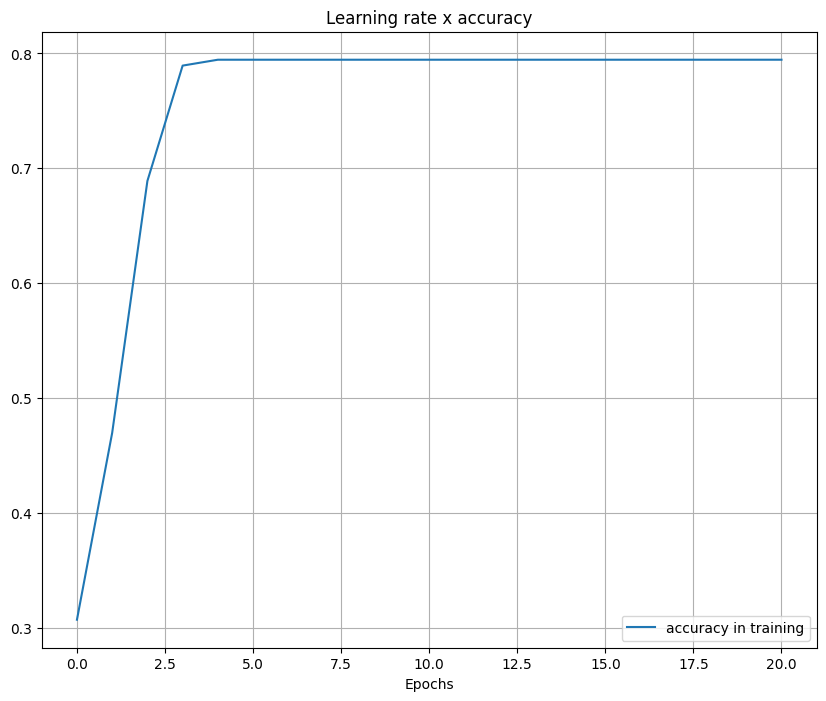

In [288]:
plt.figure(figsize = [10,8])
plt.title("Learning rate x accuracy")
plt.plot(history.history['accuracy'], label = 'accuracy in training')
plt.xlabel("Epochs")
plt.legend()
plt.grid()

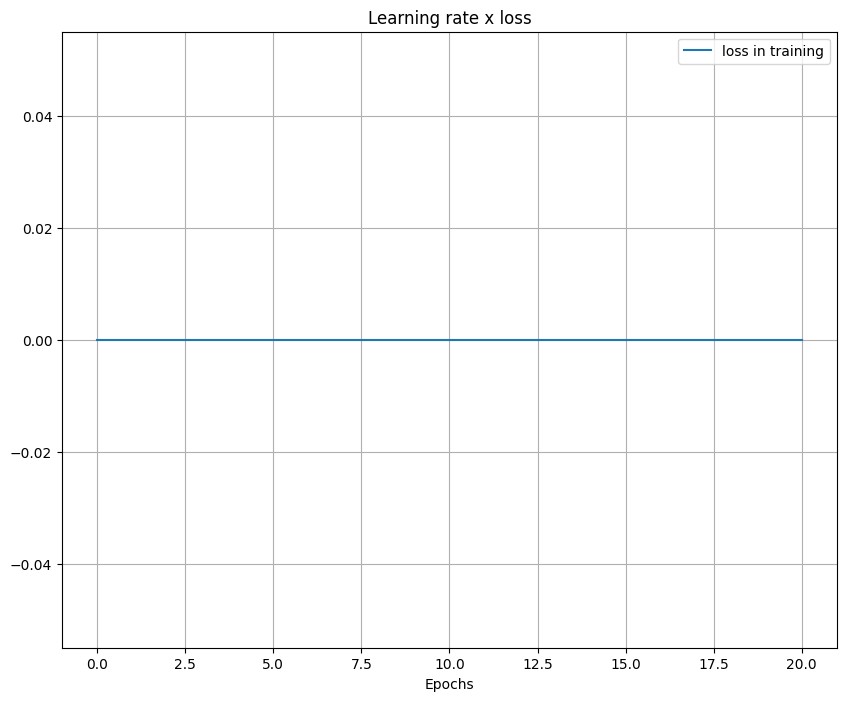

In [289]:
plt.figure(figsize = [10,8])
plt.title("Learning rate x loss")
plt.plot(history.history['loss'], label = 'loss in training')
plt.xlabel("Epochs")
plt.legend()
plt.grid()

In [290]:
# Predicting values from test data
deep_y_pred = deep_model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [291]:
deep_y_pred = (deep_y_pred > 0.5)

In [292]:
deep_accuracy = accuracy_score(y_test, deep_y_pred)
print(f"Accuracy: {deep_accuracy}")

Accuracy: 0.8035


In [293]:
lr_accuracy = accuracy_score(y_test, lr_y_pred)
print(f"Accuracy: {lr_accuracy}")

Accuracy: 0.809


## Model trainning conclusion: Logistic Regression
- Both models accuracy is similar, because of that I will select Logistic Regression as winner because it's easier to interpret.

In [294]:
# Saving the scaler
import joblib
joblib.dump(scaler, 'scaler_lr.pkl')

['scaler_lr.pkl']

In [296]:
joblib.dump(lr_model, 'lr_model_v1.pkl')

['lr_model_v1.pkl']